In [1]:
%matplotlib inline

from Utils import *

create_dir('output')

The directory output  already exists


In [2]:
def state_prep(x):
    backend = Aer.get_backend('unitary_simulator')

    x = normalize_custom(x)

    qreg = QuantumRegister(1)
    qc = QuantumCircuit(qreg)
    # Run the quantum circuit on a unitary simulator backend
    qc.initialize(x,[qreg])
    job = execute(qc, backend)
    result = job.result()
    
    U = result.get_unitary(qc)
    S = Operator(U)
    return S

In [3]:
def classic_swap_test(x,y):
    sim = dot(x, y)/(norm(x)*norm(y))
    out = 1/2 + (sim**2)/2
    return out
    
def classic_ensemble(x1, x2, x_test):
    avg = np.mean([classic_swap_test(x1, x_test), classic_swap_test(x2, x_test)])       
    return avg

In [4]:
def quantum_swap_test(a,b):
    a = normalize_custom(a)
    b = normalize_custom(b)
    
    ancilla = QuantumRegister(1, 'y')
    v1 = QuantumRegister(1, 'v_1')
    v2 = QuantumRegister(1, 'v_2')
    
    c = ClassicalRegister(1, 'c')
    
    qc = QuantumCircuit(v1, v2, ancilla, c)
    
    S1 = state_prep(a)
    qc.unitary(S1, [0], label='$S_{a}$')

    S2 = state_prep(b)
    qc.unitary(S2, [1], label='$S_{b}$')

    qc.barrier()
    
    qc.h(ancilla[0])
    qc.cswap(ancilla[0], v1[0], v2[0])
    qc.h(ancilla[0])
    qc.measure(ancilla[0], c)
    return qc

    

def quantum_ensemble(x1, x2, x_test):
    n_obs = 2
    d=1
    
    control = QuantumRegister(d, 'd')
    data = QuantumRegister(n_obs, 'x')
    temp = QuantumRegister(1, 'temp')
    data_test = QuantumRegister(1, 'x^{test}')
    avg = QuantumRegister(1, 'f_{i}')
    c = ClassicalRegister(1, 'c')

    qc = QuantumCircuit(control, data, temp, data_test, avg, c)

    S1 = state_prep(x1)
    qc.unitary(S1, [1], label='$S_x$')
    
    S2 = state_prep(x2)
    qc.unitary(S2, [2], label='$S_x$')
    
    S3 = state_prep(x_test)
    qc.unitary(S3, [4], label='$S_{x}$')
    
    qc.h(control)

    qc.barrier()

    qc.cswap(control[0], data[0], temp[0])

    qc.x(control[0])
    qc.cswap(control[0], data[1], temp[0])
    qc.barrier()
    
    
    qc.h(avg[0])
    qc.cswap(avg[0], temp[0], data_test[0])
    qc.h(avg[0])
    qc.measure(avg[0], c)
    return qc

In [9]:
seed = 123
np.random.seed(seed)

runs = 30
data = pd.DataFrame()

for i in range(runs):
    x1 = uniform(-10,10,2)
    x2 = uniform(-10,10,2)
    x_test = uniform(-10,10,2)

    row = pd.Series(np.concatenate((x1, x2, x_test)))
    data = data.append(row, ignore_index=True)

data.columns = ['x11', 'x12', 'x21', 'x22', 'x1_test', 'x2_test']
# data.to_csv('output/data.csv', index=False)
data = data.loc[18:21,:]
data

,x11,x12,x21,x22,x1_test,x2_test
18,7.089050,-2.303244,-3.664242,-2.914706,-6.578363,6.582253
19,-3.226583,1.047402,1.571029,0.430661,-9.946239,9.766908
20,8.106832,-5.847283,-4.150212,0.400203,8.038227,9.672618
21,-4.849159,1.287181,6.139374,-2.112599,4.621461,-6.778620


In [10]:
# Execution on real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend_16 = provider.get_backend('ibmq_16_melbourne')
backend_5 = provider.get_backend('ibmq_rome')

ibmqfactory.load_account:WARNING:2020-05-31 19:17:59,875: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
data_out = pd.DataFrame()
i =0
for index, rows in data.iterrows(): 

    # Extract data
    x1 =np.array([rows.x11, rows.x12])
    x2 =np.array([rows.x21, rows.x21])
    x_test = np.array([rows.x1_test, rows.x2_test])
    
    # Compute the average classically of classical swap test
    cAVG = classic_ensemble(x1, x2, x_test)
    
    # Swap test using x1 as training on simulator
    qc_x1 = quantum_swap_test(x1, x_test)
    m1 = exec_simulator(qc_x1)
    r1 = retrieve_proba(m1)
    
    # Swap test using x2 as training on simulator
    qc_x2 = quantum_swap_test(x2, x_test)
    m2 = exec_simulator(qc_x2)
    r2 = retrieve_proba(m2)
    
    # Compute the average classically
    r_avg = np.mean([r1[0],r2[0]])
    
    # Compute the average using quantum ensemble algorithm on simulator
    qc = quantum_ensemble(x1, x2, x_test)
    r = exec_simulator(qc)
    r_ens = retrieve_proba(r)

    # Using real devices
    
    # Swap test using x1 as training on real device
    qc_x1_real = quantum_swap_test(x1, x_test)
    r_x1_real = run_real_device(qc_x1_real, backend_5)
    r1_rl = retrieve_proba(r_x1_real)
    
    # Swap test using x2 as training on real device
    qc_x2_real = quantum_swap_test(x2, x_test)
    r_x2_real = run_real_device(qc_x2_real, backend_5)
    r2_rl = retrieve_proba(r_x2_real)
    
    # Compute the average classically
    r_avg_real = np.mean([r1_rl[0],r2_rl[0]])

    # Compute the average using quantum ensemble algorithm on real device
    qc = quantum_ensemble(x1, x2, x_test)
    qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)

    r_ens_real = run_real_device(qc, backend_16)
    r_ens_rl = retrieve_proba(r_ens_real)

    row = [cAVG, r1[0], r2[0], r_avg, r_ens[0], r1_rl[0], r2_rl[0], r_avg_real, r_ens_rl[0] ]

    row = pd.Series(row)
    
    print(i)
    i = i+1
    
    data_out = data_out.append(row, ignore_index=True)

data_out.columns = ['cAVG', 'qx1_sim', 'qx2_sim', 'qAVG_sim', 'qEns_sim', 'qx1_real', 'qx2_real', 'qAVG_real', 'qEns_real']
data_out.to_csv('output/data_out_18_21.csv', index=False)

0
1
2
3


In [22]:
data_out

,0,1,2,3,4,5,6,7,8
0,0.514071,0.517212,0.512817,0.515015,0.516479,0.519531,0.513794,0.516663,0.632935
1,0.750120,0.999878,0.511597,0.755737,0.754761,0.818970,0.510986,0.664978,0.673706
2,0.734984,0.799927,0.666626,0.733276,0.732666,0.706177,0.576050,0.641113,0.545288
3,0.696038,0.840942,0.553467,0.697205,0.687012,0.647583,0.515137,0.581360,0.619873
4,0.967991,0.984131,0.953003,0.968567,0.970337,0.708740,0.810791,0.759766,0.671021
5,0.972389,0.997925,0.947632,0.972778,0.972290,0.718872,0.729004,0.723938,0.571411
6,0.675724,0.566040,0.789062,0.677551,0.676636,0.537598,0.634277,0.585938,0.701904


In [23]:
data_out.columns = ['cAVG', 'qx1_sim', 'qx2_sim', 'qAVG_sim', 'qEns_sim', 'qx1_real', 'qx2_real', 'qAVG_real', 'qEns_real']
data_out.to_csv('output/data_out_10_17.csv', index=False)

In [16]:
p0_avg = data_out.qAVG_sim
p0_ens = data_out.qEns_sim
p0_clas = data_out.cAVG

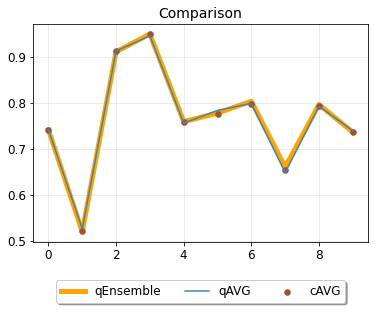

In [17]:
x = np.arange(runs)

ax = plt.subplot()
ax.plot(x, p0_ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax.plot(x, p0_avg, color='steelblue', label='qAVG')
ax.scatter(x, p0_clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
ax.set_title('Comparison', size=14)
ax.tick_params(labelsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.15),
          ncol=4, fancybox=True, shadow=True, fontsize = 12)
plt.savefig('output/simulator.png', dpi = 300, bbox_inches='tight')

In [18]:
p0_avg = data_out.qAVG_real
p0_ens = data_out.qEns_real
p0_clas = data_out.cAVG

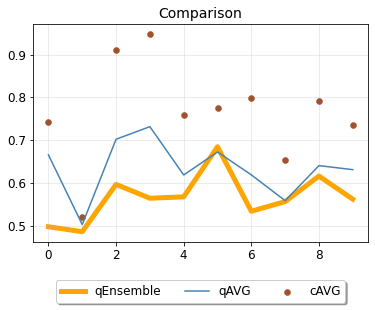

In [19]:
x = np.arange(runs)

ax = plt.subplot()
ax.plot(x, p0_ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax.plot(x, p0_avg, color='steelblue', label='qAVG')
ax.scatter(x, p0_clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
ax.set_title('Comparison', size=14)
ax.tick_params(labelsize=12)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -.15),
          ncol=4, fancybox=True, shadow=True, fontsize = 12)
plt.savefig('output/real.png', dpi = 300, bbox_inches='tight')

In [22]:
ttest_ind(p0_ens, p0_clas)

Ttest_indResult(statistic=-4.684692913494787, pvalue=0.00018453838027124653)

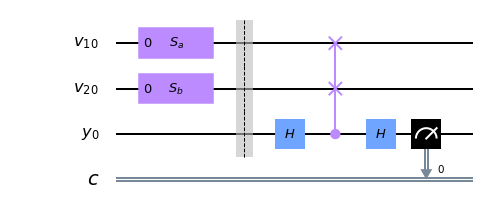

In [24]:
qc = quantum_swap_test(x1, x2)
qc.draw(output='mpl')

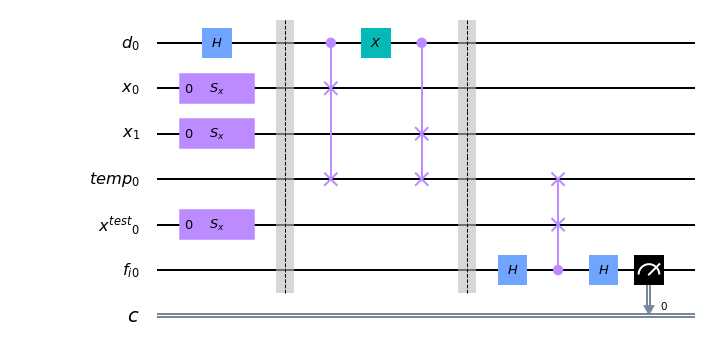

In [25]:
qc = quantum_ensemble(x1, x2, x_test)
qc.draw(output='mpl')

In [ ]:
# plt.plot(np.arange(runs), p0_ens, marker='o', color='blue', label='Ens')
# plt.plot(np.arange(runs), p0_avg, marker='o', color='orange', label = 'qAVG')
# plt.plot(np.arange(runs), p0_clas, marker='o', color='green', label = 'cAVG')

# plt.title('Comparison: AVG vs Ensemble', size=12).set_position([.5, 1.05])
# plt.xlabel('runs', size=12)
# plt.ylabel(r'$P(\tilde{y}=1)$', size =12)
# plt.xticks(np.arange(0, runs+1, 5), size = 12)
# plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], size = 12)
# plt.ylim(.4,1)
# plt.grid(alpha=.3)
# plt.legend()
# plt.savefig('multi_run.png', dpi = 300)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,3))

p0_avg = data_out.qAVG_sim
p0_ens = data_out.qEns_sim
p0_clas = data_out.cAVG

#ax = plt.subplot(221)

ax.plot(x, p0_ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax.plot(x, p0_avg, color='steelblue', label='qAVG')
ax.scatter(x, p0_clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
#ax.set_title('Comparison', size=14)
ax.tick_params(labelsize=12)


avg = data_out.qAVG_real
ens = data_out.qEns_real
clas = data_out.cAVG

#ax1 = plt.subplot(222)

ax1.plot(x, ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax1.plot(x, avg, color='steelblue', label='qAVG')
ax1.scatter(x, clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax1.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
#ax.set_title('Comparison', size=14)
ax1.tick_params(labelsize=12)
# plt.legend(loc='lower center',# bbox_to_anchor=(0.5, -.15),
#           ncol=3, fancybox=True, shadow=True, fontsize = 12)
handles, labels = ax.get_legend_handles_labels()
lgd=fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.4, -.025))

plt.savefig('output/experiments.png', dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()



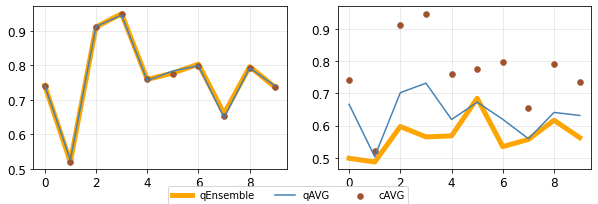

In [76]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,3))

p0_avg = data_out.qAVG_sim
p0_ens = data_out.qEns_sim
p0_clas = data_out.cAVG

#ax = plt.subplot(221)

ax.plot(x, p0_ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax.plot(x, p0_avg, color='steelblue', label='qAVG')
ax.scatter(x, p0_clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
#ax.set_title('Comparison', size=14)
ax.tick_params(labelsize=12)


avg = data_out.qAVG_real
ens = data_out.qEns_real
clas = data_out.cAVG

#ax1 = plt.subplot(222)

ax1.plot(x, ens, color='orange', label='qEnsemble', zorder=1, linewidth=5)
ax1.plot(x, avg, color='steelblue', label='qAVG')
ax1.scatter(x, clas, label='cAVG', color='sienna', zorder=2, linewidth=.5)

#ax.set_xlim(-1.1, 1.1)
# ax.set_ylim(-.2, 1.05)
ax1.grid(alpha=0.3)
#ax.set_xticks(np.round(np.arange(-1, 1.1, .4), 1).tolist())
#ax.set_title('Comparison', size=14)
ax1.tick_params(labelsize=12)
# plt.legend(loc='lower center',# bbox_to_anchor=(0.5, -.15),
#           ncol=3, fancybox=True, shadow=True, fontsize = 12)
handles, labels = ax.get_legend_handles_labels()
lgd=fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.4, -.025))

plt.savefig('output/experiments.png', dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
plt.close()

